In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import networkx as nx
from collections import Counter
import math

class Buffalo:
    def __init__(self, name, x_position, y_position, abstention_rate, voting_bias):
        self.name = name
        self.x = x_position
        self.y = y_position
        self.position = [x_position, y_position]
        
        a = np.random.uniform(0, 1)
        if a < abstention_rate:
            self.vote = 0  # not an active voter
        else:
            b = np.random.uniform(0, 1)
            if b > voting_bias:
                self.vote = 1  # votes for A
            else:
                self.vote = -1  # votes for B

def generate_herd(plane_length, herd_positions, abstention_rate, voting_bias): 
    while True:
        # Generate unique position (x, y)
        radius = np.sqrt(np.random.uniform(0, 1)) * plane_length/2
        theta = np.random.uniform(0, 2 * np.pi)
        x = radius * np.cos(theta) + plane_length
        y = radius * np.sin(theta) + plane_length
        
        new_position = [x, y]
        
        # Ensure position uniqueness
        if new_position not in herd_positions:
            herd_positions.append(new_position),
            name = len(herd_positions) - 1
            return Buffalo(name, x, y, abstention_rate, voting_bias)

def simulate_herd(vision_range, herd_size, abstention_rate, voting_bias, plane_length=100):
    # Initialize herd and position set
    herd = []
    herd_positions = []
    
    # Generate a herd
    for i in range(herd_size):
        herd.append(generate_herd(plane_length, herd_positions, abstention_rate, voting_bias))
    
    # Extract positions into a numpy array
    # Build a k-d tree
    tree = cKDTree(herd_positions)
    
    # Find all pairs within range r
    neighbours = tree.query_pairs(vision_range)
    paired_buffaloes = list(neighbours)

    
    # Create a networkx graph
    network_buffalos = nx.Graph()
    
    # Add all buffaloes as nodes (even if they have no neighbors)
    for i in range(len(herd)):
        network_buffalos.add_node(i)  # Add node for each buffalo
    
    # Add edges (neighbours) to the graph
    network_buffalos.add_edges_from(neighbours)
    
    # Get the largest connected component and its size
    largest_cc = max(nx.connected_components(network_buffalos), key=len)
    largest_cc_size = len(largest_cc)
    cc_ratio = largest_cc_size / herd_size * 100
    
    # Categorize herd by vote
    no_vote = [buff for buff in herd if buff.vote == 0]
    vote_a = [buff for buff in herd if buff.vote == 1]
    vote_b = [buff for buff in herd if buff.vote == -1]


    #Compute where the buffalo thinks the herd is going based on neighbours 
    for buff in herd:
        buff.decision = buff.vote 
        
    for pair in paired_buffaloes:
        buff_a = next(buff for buff in herd if buff.name == pair[0])
        buff_b = next(buff for buff in herd if buff.name == pair[1])

        # Add the vote of each buffalo to the other's decision
        buff_a.decision += buff_b.vote
        buff_b.decision += buff_a.vote

    #normalize decision
    for buff in herd:
        buff.decision = np.sign(buff.decision)

    #define ratio of success
    initial_votes = [buff.vote for buff in herd]
    majority_initial_vote = np.sum(initial_votes)
    decisions = [buff.decision for buff in herd]
    majority_decision = np.sum(decisions)
    vote_counts = Counter(buff.decision for buff in herd)
    
    if np.sign(majority_initial_vote) != np.sign(majority_decision) or np.sign(majority_initial_vote) == 0 or np.sign(majority_decision) == 0:
        success_rate = 0
    else:
        success_rate = (max(vote_counts.values()) / herd_size) * 100
        
    return herd, paired_buffaloes, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate


def results(herd, no_vote, vote_a, vote_b, paired_buffaloes, cc_ratio, largest_cc_size, plane_length=100):
    color_map = {0: 'grey', 1: 'blue', -1: 'red'}
    voting_record = {0: 'No vote', 1: 'Vote A', -1: 'Vote B'}
    voting_record_2 = {0: 'Undecided', 1: 'Going A', -1: 'Going B'}
    
    # Plot the herd
    plt.figure(figsize=(8, 7))
    for buff in herd:
        plt.scatter(buff.x, buff.y, s=1.2, color=color_map[buff.vote], label=voting_record[buff.vote])
    
    # Adding legend and labels
    plt.xlabel('Plane (X-axis)')
    plt.ylabel('Plane (Y-axis)')
    plt.xlim(0, 2 * plane_length)
    plt.ylim(0, 2 * plane_length)
    plt.title('Herd with assigned votes')
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'{voting_record[v]}', 
                   markerfacecolor=color, markersize=10)
        for v, color in color_map.items()],
               title='Legend', loc='upper right')
    plt.show()
    
    # Print tally results
    print(
        f'Tally:\nNo vote : {len(no_vote)}\n'
        f'Direction A : {len(vote_a)}\n'
        f'Direction B : {len(vote_b)}'
    )
    
    # Create and plot the network
    network_buffalos = nx.Graph()
    
    # Add all buffaloes as nodes (even if they have no neighbors)
    for i in range(len(herd)):
        network_buffalos.add_node(i)
    
    # Add edges (neighbours) to the graph
    network_buffalos.add_edges_from(paired_buffaloes)
    
    # Now, all buffaloes are in the network (including unpaired ones)
    # Map buffalo votes to node colors
    node_colors = [color_map[buff.vote] for buff in herd]
    
    # Draw the network
    plt.figure(figsize=(8, 7))
    nx.draw(network_buffalos, arrows=True, with_labels=False, node_color=node_colors, 
            node_size=20, edge_color='black')
    plt.title('Buffalo Network')
    plt.show()
    
    # Print largest connected component results
    print(
        f'The largest connected subgroup is made of {largest_cc_size} buffaloes \n'
        f'{cc_ratio:.0f}% of the herd is connected'
    )

    plt.figure(figsize=(8, 7))
    for buff in herd:
        plt.scatter(buff.x, buff.y, s=1.2, color=color_map[buff.decision], label=voting_record_2[buff.decision])
    
    # Adding legend and labels
    plt.xlabel('Plane (X-axis)')
    plt.ylabel('Plane (Y-axis)')
    plt.xlim(0, 2 * plane_length)
    plt.ylim(0, 2 * plane_length)
    plt.title("Herd's Direction")
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'{voting_record_2[v]}', 
                   markerfacecolor=color, markersize=10)
        for v, color in color_map.items()],
               title='Legend', loc='upper right')
    plt.show()

    # Categorize herd by decision
    undecided = [buff for buff in herd if buff.decision == 0]
    going_a = [buff for buff in herd if buff.decision == 1]
    going_b = [buff for buff in herd if buff.decision == -1]

    print(
        f'New Tally:\nUndecided : {len(undecided)}\n'
        f'Direction A : {len(going_a)}\n'
        f'Direction B : {len(going_b)}'
    )

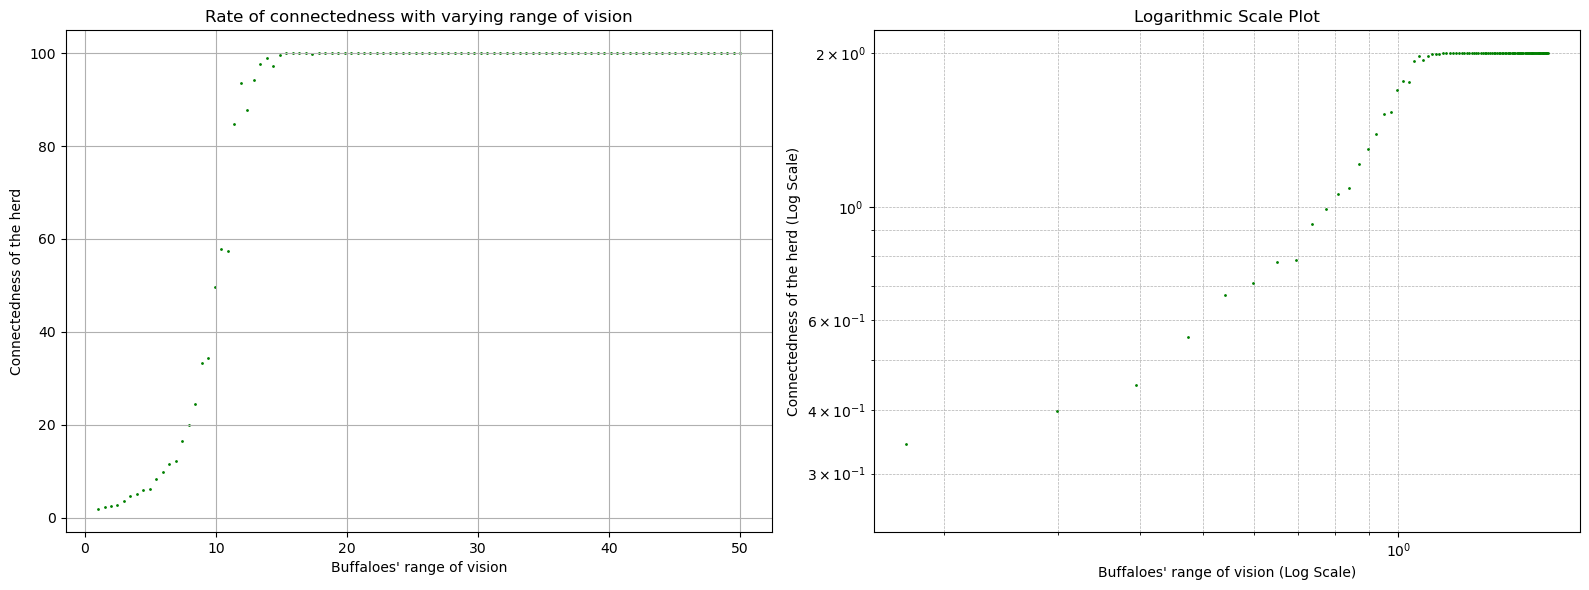

In [23]:
import math

vision_range_r = np.linspace(1, 50, 100)
connectivity = []
abstention_rate = 0.0
voting_bias = .5

for i in vision_range_r:
    con = []
    for _ in range(10):
        herd, paired_buffaloes, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate = simulate_herd(vision_range = i,
        herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        con.append(cc_ratio)
    j = np.mean(con)
    connectivity.append(j)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot (scatter plot)
axes[0].scatter(vision_range_r, connectivity, s=1, color='green')
axes[0].set_xlabel("Buffaloes' range of vision")
axes[0].set_ylabel('Connectedness of the herd')
axes[0].set_title('Rate of connectedness with varying range of vision')
axes[0].grid(True)

# Second subplot (log-log plot)
connectivity_log = [math.log10(x) for x in connectivity]
vision_range_r_log = [math.log10(x) for x in vision_range_r]

axes[1].loglog(vision_range_r_log, connectivity_log, marker='o', linestyle='', color='green', markersize=1)
axes[1].set_xlabel("Buffaloes' range of vision (Log Scale)")
axes[1].set_ylabel("Connectedness of the herd (Log Scale)")
axes[1].set_title("Logarithmic Scale Plot")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig('Connect_range_vision.png', dpi=300)
plt.show()

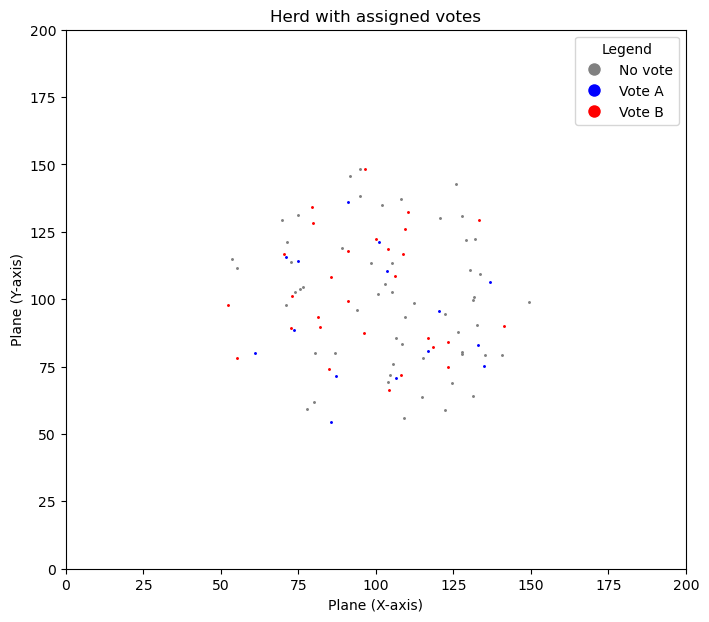

Tally:
No vote : 56
Direction A : 15
Direction B : 29


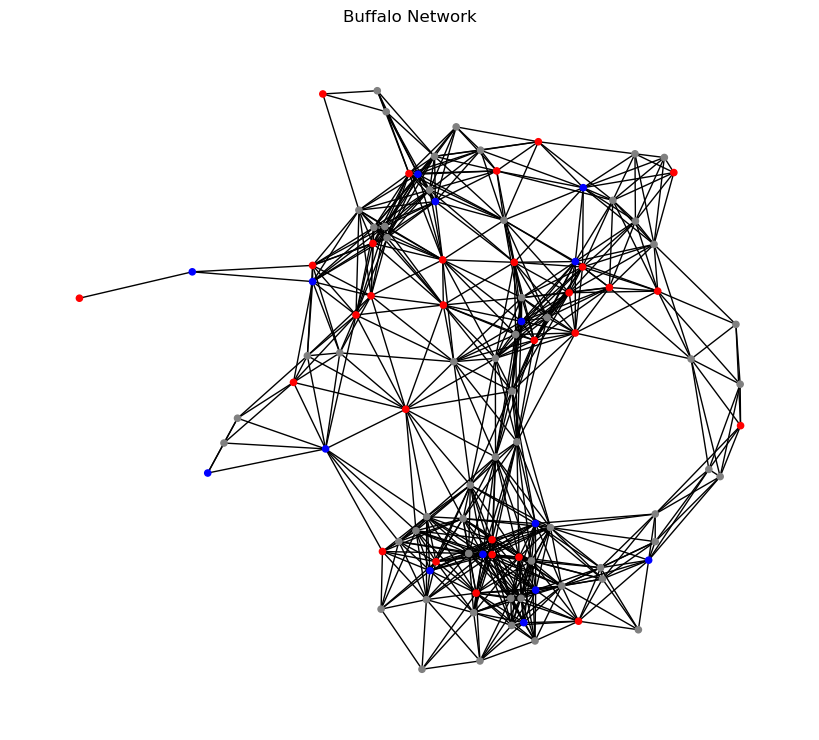

The largest connected subgroup is made of 100 buffaloes 
100% of the herd is connected


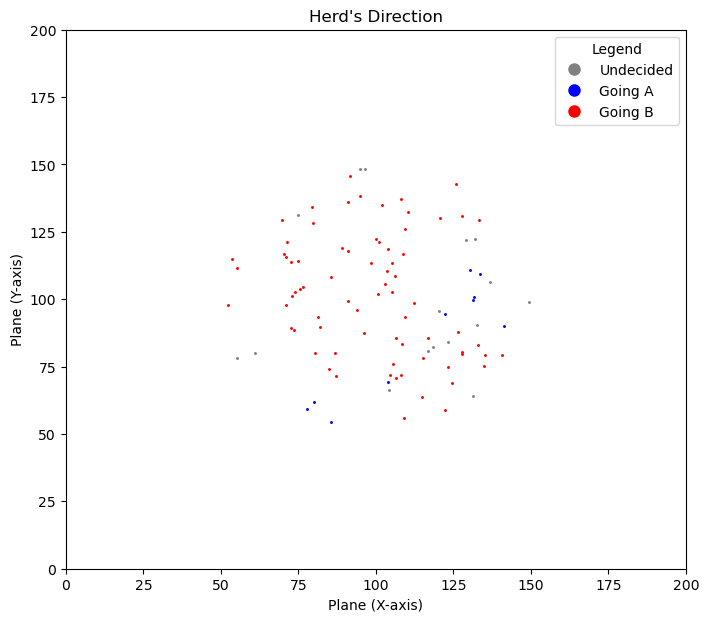

New Tally:
Undecided : 16
Direction A : 10
Direction B : 74


In [31]:
#Test run
vision_range = 19

herd_size = 100
abstention_rate = .55
voting_bias = .5
    
herd, paired_buffaloes, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate = simulate_herd(vision_range, herd_size, abstention_rate, voting_bias)
results(herd, no_vote, vote_a, vote_b, paired_buffaloes, cc_ratio, largest_cc_size)

Among all runs, how many failed democratically speaking (success_rate = 0) ? Among the ones that succeeded, to what extent did they ?

In [ ]:
%%time

vision_range_r = np.linspace(1, 50, 100)
success = []
abstention_rate = 0
voting_bias = .5
failure_rate = []

for i in vision_range_r:
    con = []
    for _ in range(100):
        herd, paired_buffaloes, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate = simulate_herd(vision_range = i, herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        if success_rate != 0:
            con.append(success_rate)
    success.append(np.mean(con))
    failure_rate.append(100-len(con))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot (scatter plot)
axes[0].scatter(vision_range_r, success, s=1, color='green')
axes[0].bar(vision_range_r, failure_rate, width=1, color='red')
axes[0].set_xlabel("Buffaloes' range of vision")
axes[0].set_ylabel('Success of the vote')
axes[0].set_title("Rate of vote's success with varying range of vision")
axes[0].grid(True)

# Second subplot (log-log plot)
success_log = [math.log10(x) for x in success]
vision_range_r_log = [math.log10(x) for x in vision_range_r]

axes[1].loglog(vision_range_r_log, success_log, marker='o', linestyle='', color='green', markersize=1)
axes[1].set_xlabel("Buffaloes' range of vision (Log Scale)")
axes[1].set_ylabel("Success of the vote (Log Scale)")
axes[1].set_title("Logarithmic Scale Plot")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig('success_vs_range_vision.png', dpi=300)
plt.show()

Plot the average number of neighbours with this

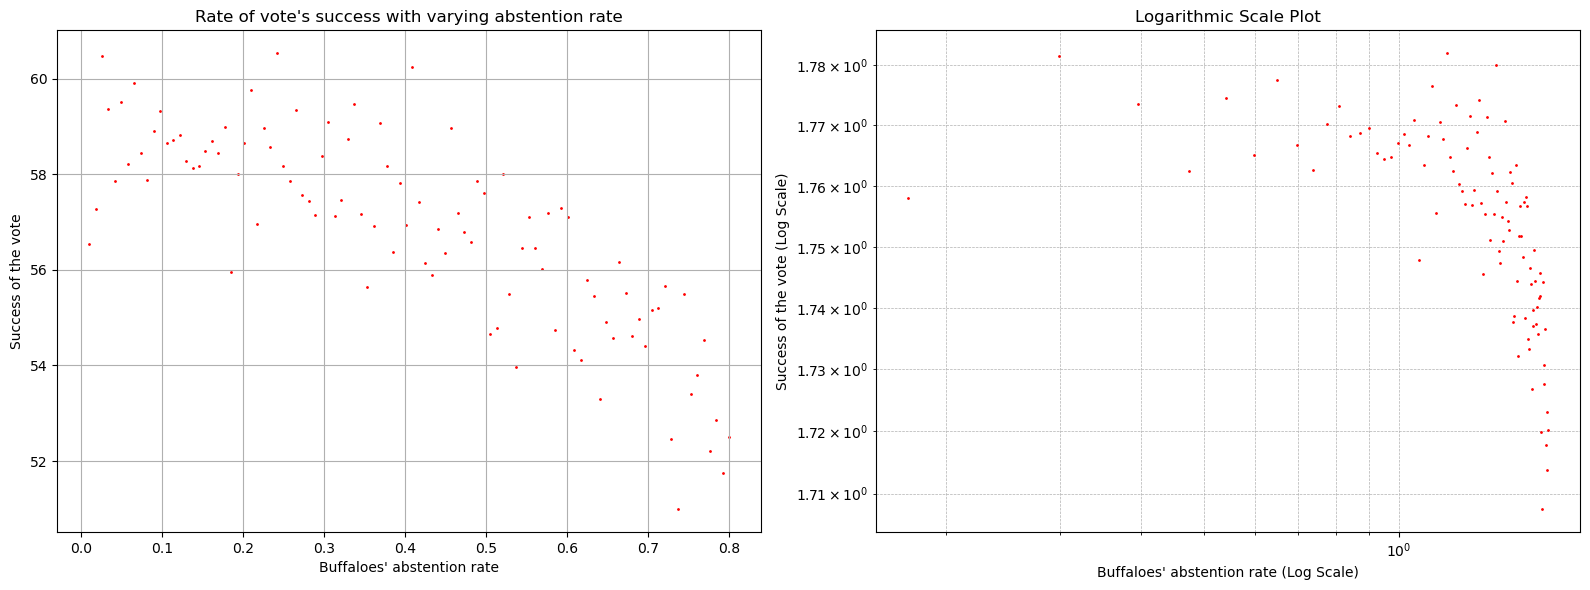

CPU times: total: 2min 5s
Wall time: 2min 19s


In [18]:
%%time

vision_range = 20 
success = []
abstention_rate_r = np.linspace(0.01, .8, 100)
voting_bias = .5

for i in abstention_rate_r:
    con = []
    for _ in range(100):
        herd, paired_buffaloes, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate = simulate_herd(vision_range = vision_range, herd_size=100, abstention_rate = i, voting_bias = voting_bias)
        if success_rate != 0:
            con.append(success_rate)
    success.append(np.mean(con))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot (scatter plot)
axes[0].scatter(abstention_rate_r, success, s=1, color='red')
axes[0].set_xlabel("Buffaloes' abstention rate")
axes[0].set_ylabel('Success of the vote')
axes[0].set_title("Rate of vote's success with varying abstention rate")
axes[0].grid(True)

# Second subplot (log-log plot)
success_log = [math.log10(x) for x in success]
abstention_rate_r_log = [math.log10(x) for x in vision_range_r]

axes[1].loglog(abstention_rate_r_log, success_log, marker='o', linestyle='', color='red', markersize=1)
axes[1].set_xlabel("Buffaloes' abstention rate (Log Scale)")
axes[1].set_ylabel("Success of the vote (Log Scale)")
axes[1].set_title("Logarithmic Scale Plot")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig('success_vs_abstention_rate.png', dpi=300)
plt.show()

How representative are these successes compared to the original votes ? how many where 'swayed' ?